In [176]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
from posixpath import split
import pandas as pd
import re
import csv  
import os

def get_all_posts(path): #function to read all .txt files under a directory
  # read specific columns of csv file using Pandas
  df = pd.read_csv(path, usecols = ['comment_text','gender', 'label'])
  # Only keep the un-offensive comments
  df_new = df[df['label'] == 0] # choose onlz the non/offensive ones
  # print(df_new.iloc[0])
  df = df_new[['comment_text', 'gender']]
  return df

In [178]:
import random

# data paths determined
path = "/content/drive/MyDrive/Thesis/GenderDetection(SWSR)/SexComment.csv"
df = get_all_posts(path)


male_df = df.loc[df['gender'] == '男']
female_df = df.loc[df['gender'] == '女']

male_posts = male_df['comment_text'].tolist()
female_posts = female_df['comment_text'].tolist()

random.Random(4).shuffle(male_posts)
random.Random(4).shuffle(female_posts)



In [179]:
import jieba

def train_test_set(pos_texts, neg_texts):


  def text_segment(texts): 

    # jieba.enable_paddle()# 启动paddle模式。
    jieba.enable_parallel(10)

    seg_post = []

    for strs in texts:
    
      seg_list = jieba.cut(strs) # this  step returns the list directly 
      tmp = " ".join(seg_list)
      seg_post.append(tmp)

    return seg_post


  new_pos_texts = text_segment(pos_texts)

  new_neg_texts = text_segment(neg_texts)

  
  return new_pos_texts, new_neg_texts

In [180]:
male, female= train_test_set(male_posts, female_posts)
print(len(male), len(female))

new_male = male[:500]
new_female = female[:500]
all_labels = ['male']*500 + ['female']*500
all_posts = new_male + new_female 
# print(new_male[:3])
# print(new_female[:3])
vali_X = male[500:600] + female[500:600] # altogether 200 posts in validation set
vali_Y = ['male']*100 + ['female']*100
print(vali_X[:3])
print(vali_Y[:3])
test_X = male[600:1100] + female[600:1100] # altogether 1000 posts in test set
test_Y = ['male']*500 + ['female']*500

all_train_male = new_male + male[1100:1884]
all_train_female = new_female + female[1100:1884]
all_train_posts = all_train_male + all_train_female
all_train_labels = ['male']*1284 + ['female']*1284


1884 3992
['其实 现在 这些 看多 了 都 正常 了 ， 什么 东西 做 过度 做 多 了 都 会 被 当成 靶子 的 。 。 。', '别太 介意 网上 那些 喷子 ， 做 你 自己 ， 能 坚持 初心 的 人 就 很 了不起 了 ， 别 让 他们 得逞', '这 不 就是 抖个 机灵 一句 玩笑话 吗 … … 怎么 这么 多人 上纲上线 了 还 … … 脑阔 疼']
['male', 'male', 'male']


In [181]:
print(len(all_posts), len(test_X), len(all_train_male))

1000 1000 1284


In [182]:
import pandas as pd
from io import StringIO


df = pd.DataFrame(list(zip(all_posts, all_labels)),
              columns=['sentences','label_desc'])

vali_df = pd.DataFrame(list(zip(vali_X, vali_Y)),
              columns=['sentences','label_desc'])

test_df = pd.DataFrame(list(zip(test_X, test_Y)),
              columns=['sentences','label_desc'])

all_df = pd.DataFrame(list(zip(all_train_posts, all_train_labels)),
              columns=['sentences','label_desc'])


new_df = pd.concat([df, vali_df, test_df, all_df], axis=0)

col = ['label_desc', 'sentences']
new_df = new_df[col]
new_df = new_df[pd.notnull(new_df['sentences'])]
new_df.columns = ['label_desc', 'sentences']
new_df['category_id'] = new_df['label_desc'].factorize()[0]

category_id_df = new_df[['label_desc', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label_desc']].values)
new_df.head()

df = new_df[:1000]
vali_df = new_df[1000:1200] # altogether 200 posts in validation set
test_df = new_df[1200:2200] # altogether 1000 posts in test set

final_train_df = new_df[2200:]

print(len(final_train_df))

test_df.head()

2568


,label_desc,sentences,category_id
0,male,"我 还 看到 一个 说 自己 妈 是 婚 驴 ， 不 知道 是不是 反串 的 , 她们 甚至...",0
1,male,国外 网友 也 差不多 一样 绑架 所有人 所以 外国 的 月亮 真的 没有 比...,0
2,male,李 叔叔 写 了 十几篇 骂 女拳 的 文章 啊 ， 酣畅淋漓 ， 还 找 得到 不 ？ 没...,0
3,male,没事 没事 😂 ， 但 作为 外人 根据 已有 证据 来看 伍迪 艾伦 是 无罪 的 ， 但...,0
4,male,其实 你 不 需要 说 这么 多 ， 在 这类 恶性事件 中 ， 任何 说出 “ 受害者 有...,0


In [183]:
### Defining the model and tuning process ###

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score,recall_score,precision_score,f1_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid

def SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test):

    clf = LinearSVC()

    best_score = 0
    # defining parameter range
    grid = {
            'C': [0.001, 0.1, 1, 10, 25, 50, 100], 
            
            
        }
    paramGrid = ParameterGrid(grid)
    for params in paramGrid:
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            # PREDICT VALUE BASED ON UPDATED PARAMETERS
            y_vali_result = clf.predict(vali_X)
            f1 = f1_score(vali_Y,y_vali_result, average = 'macro')
            if f1 > best_score:
                  best_score = f1
                  best_grid = params
    print(type(y_vali_result))
    print(type(vali_X))

    print("Best score:", best_score )
    print("Grid:", best_grid)
    # # NEW MODEL EVALUATION METRICS 
    t = LinearSVC()
    model = t.set_params(**best_grid)
    model.fit(X_train,y_train)
    # print(type(test_X))
    y_pred_test = model.predict(X_test)
    print(type(y_pred_test))
    print(type(y_test))
    print("####################################")
    print("By using SVC model, the best parameter and its evaluation metrics are:")
    accuracy = accuracy_score(y_test,y_pred_test)
    precision = precision_score(y_test,y_pred_test, average = 'macro')
    recall = recall_score(y_test,y_pred_test, average = 'macro')
    f1 = f1_score(y_test,y_pred_test, average = 'macro')
    print('Best parameters: ' + str(model))
    print('Accuracy Score : ' + str(accuracy))
    print('Precision Score : ' + str(precision))
    print('Recall Score : ' + str(recall))
    print('F1 Score : ' + str(f1))
    return f1



In [184]:
# remove the label which has the least samples, then increase the size of dataframe by 100 per group
# then randomly select same amount of samples from the left categories

df_100 = df.sample(n = 100, random_state = 2)
df_200 = df.sample(n = 200, random_state = 2)
df_300 = df.sample(n = 300, random_state = 2)
df_400 = df.sample(n = 400, random_state = 2)
df_500 = df.sample(n = 500, random_state = 2)
df_600 = df.sample(n = 600, random_state = 2)
df_700 = df.sample(n = 700, random_state = 2)
df_800 = df.sample(n = 800, random_state = 2)
df_900 = df.sample(n = 900, random_state = 2)
df_1000 = df.sample(n = 1000, random_state = 2)



print(df_700.groupby('label_desc').size())

label_desc
female    347
male      353
dtype: int64


In [185]:
########################### Data Size = 100 ##################################

female    56
male      44
Name: label_desc, dtype: int64


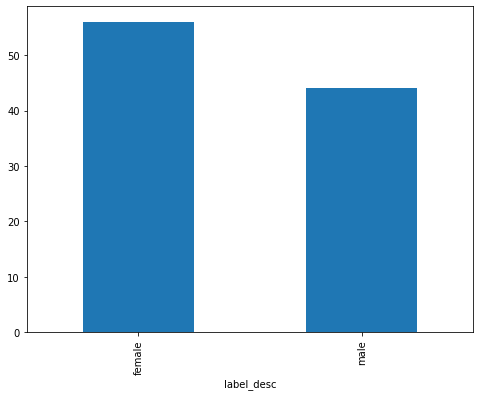

In [186]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_100.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_100['label_desc'].value_counts())
plt.show()

In [187]:
df_0 = pd.concat([df_100, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape 

(1300, 1674)

In [188]:
X_train = features[:100]
vali_X = features[100:300]
y_train = labels[:100]
vali_Y = labels[100:300]
X_test = features[300:]
y_test = labels[300:]
print(type(X_test))

f1_100 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.4931897370921761
Grid: {'C': 25}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=25)
Accuracy Score : 0.514
Precision Score : 0.5155530670648252
Recall Score : 0.514
F1 Score : 0.501556865592655


In [189]:
########################### Data Size = 200 ##################################

female    102
male       98
Name: label_desc, dtype: int64


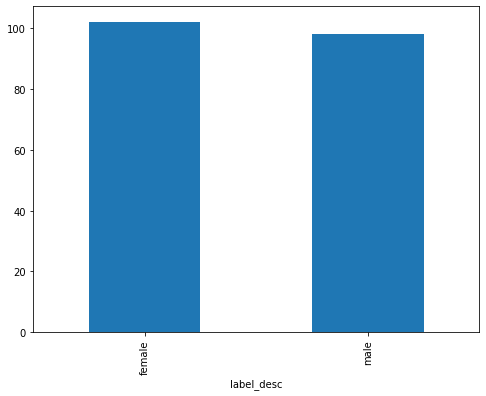

In [190]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_200.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_200['label_desc'].value_counts())
plt.show()

In [191]:
df_0 = pd.concat([df_200, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(1400, 1810)

In [192]:
X_train = features[:200]
vali_X = features[200:400] # altogether 200 posts in validation set
y_train = labels[:200]
vali_Y = labels[200:400]
X_test = features[400:]
y_test = labels[400:]
# print(type(X_test))

f1_200 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.5784126984126984
Grid: {'C': 0.1}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=0.1)
Accuracy Score : 0.514
Precision Score : 0.514739572805067
Recall Score : 0.514
F1 Score : 0.5078261714952363


In [193]:
########################### Data Size = 300 ##################################

female    151
male      149
Name: label_desc, dtype: int64


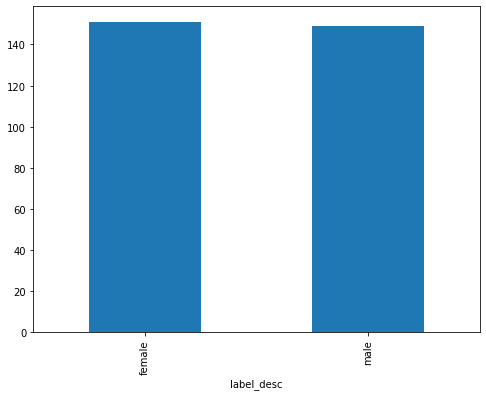

In [194]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_300.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_300['label_desc'].value_counts())
plt.show()

In [195]:
df_0 = pd.concat([df_300, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(1500, 1927)

In [196]:
X_train = features[:300]
vali_X = features[300:500] # altogether 200 posts in validation set
y_train = labels[:300]
vali_Y = labels[300:500]
X_test = features[500:]
y_test = labels[500:]
# print(type(X_test))

f1_300 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.5798319327731092
Grid: {'C': 0.1}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=0.1)
Accuracy Score : 0.533
Precision Score : 0.533096509421473
Recall Score : 0.533
F1 Score : 0.5326593086359956


In [197]:
########################### Data Size = 400 ##################################

female    202
male      198
Name: label_desc, dtype: int64


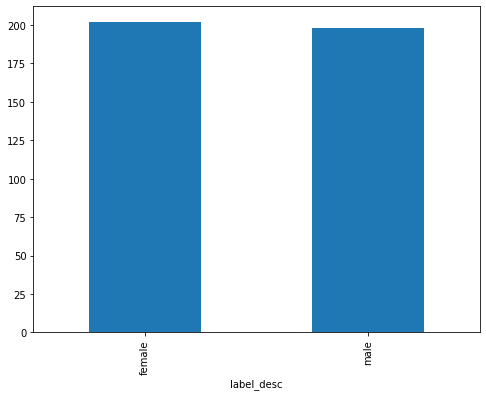

In [198]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_400.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_400['label_desc'].value_counts())
plt.show()

In [199]:
df_0 = pd.concat([df_400, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(1600, 2087)

In [200]:
X_train = features[:400]
vali_X = features[400:600] # altogether 200 posts in validation set
y_train = labels[:400]
vali_Y = labels[400:600]
X_test = features[600:]
y_test = labels[600:]
# print(type(X_test))

f1_400 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.6193910256410255
Grid: {'C': 0.1}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=0.1)
Accuracy Score : 0.564
Precision Score : 0.5648729301480724
Recall Score : 0.5640000000000001
F1 Score : 0.5625283453537702


In [201]:
########################### Data Size = 500 ##################################

male      250
female    250
Name: label_desc, dtype: int64


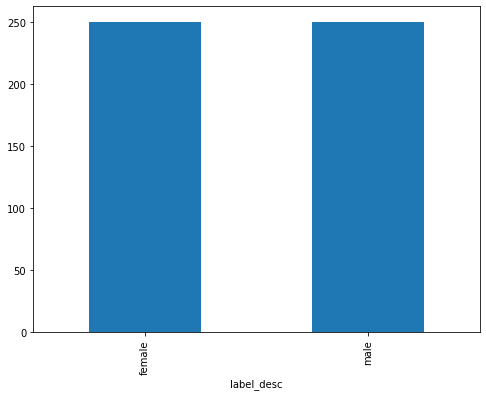

In [202]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_500.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_500['label_desc'].value_counts())
plt.show()

In [203]:
df_0 = pd.concat([df_500, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(1700, 2233)

In [204]:
X_train = features[:500]
vali_X = features[500:700] # altogether 200 posts in validation set
y_train = labels[:500]
vali_Y = labels[500:700]
X_test = features[700:]
y_test = labels[700:]
# print(type(X_test))

f1_500 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.5749893747343684
Grid: {'C': 0.1}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=0.1)
Accuracy Score : 0.538
Precision Score : 0.5380097304910056
Recall Score : 0.538
F1 Score : 0.5379704301075269


In [205]:
########################### Data Size = 600 ##################################

male      304
female    296
Name: label_desc, dtype: int64


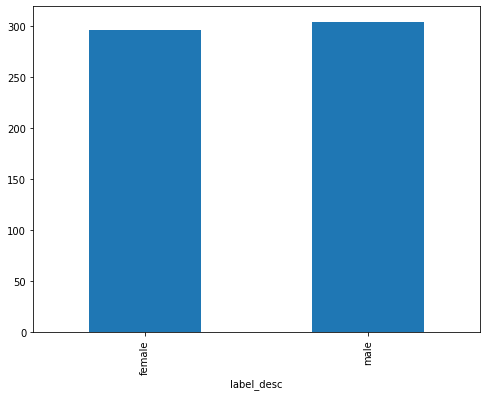

In [206]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_600.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_600['label_desc'].value_counts())
plt.show()

In [207]:
df_0 = pd.concat([df_600, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(1800, 2363)

In [208]:
X_train = features[:600]
vali_X = features[600:800] # altogether 200 posts in validation set
y_train = labels[:600]
vali_Y = labels[600:800]
X_test = features[800:]
y_test = labels[800:]
# print(type(X_test))

f1_600 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.5749043534795328
Grid: {'C': 1}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=1)
Accuracy Score : 0.536
Precision Score : 0.5361480624638519
Recall Score : 0.536
F1 Score : 0.535524376962009


In [209]:
########################### Data Size = 700 ##################################

male      353
female    347
Name: label_desc, dtype: int64


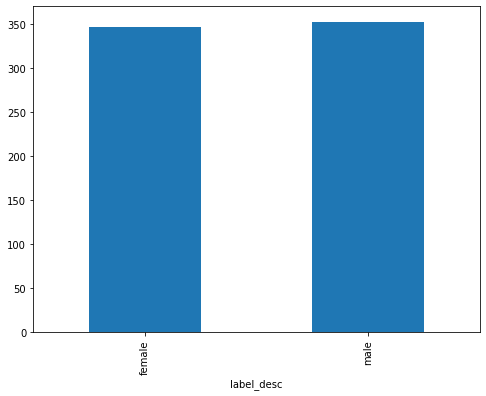

In [210]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_700.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_700['label_desc'].value_counts())
plt.show()

In [211]:
df_0 = pd.concat([df_700, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(1900, 2470)

In [212]:
X_train = features[:700]
vali_X = features[700:900] # altogether 200 posts in validation set
y_train = labels[:700]
vali_Y = labels[700:900]
X_test = features[900:]
y_test = labels[900:]
# print(type(X_test))

f1_700 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.5598239295718288
Grid: {'C': 0.1}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=0.1)
Accuracy Score : 0.559
Precision Score : 0.5593994015761984
Recall Score : 0.5589999999999999
F1 Score : 0.5582574307410757


In [213]:
########################### Data Size = 800 ##################################

male      409
female    391
Name: label_desc, dtype: int64


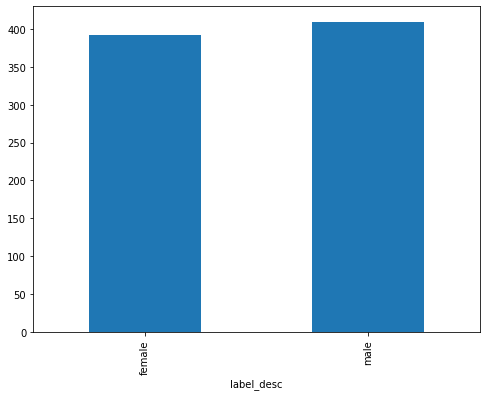

In [214]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_800.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_800['label_desc'].value_counts())
plt.show()

In [215]:
df_0 = pd.concat([df_800, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(2000, 2630)

In [216]:
X_train = features[:800]
vali_X = features[800:1000] # altogether 200 posts in validation set
y_train = labels[:800]
vali_Y = labels[800:1000]
X_test = features[1000:]
y_test = labels[1000:]
# print(type(X_test))

f1_800 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.5610383713009914
Grid: {'C': 0.1}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=0.1)
Accuracy Score : 0.558
Precision Score : 0.5590285128071518
Recall Score : 0.558
F1 Score : 0.5560662244738079


In [217]:
########################### Data Size = 900 ##################################

male      452
female    448
Name: label_desc, dtype: int64


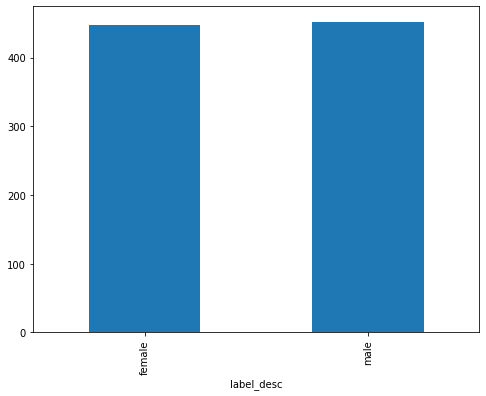

In [218]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_900.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_900['label_desc'].value_counts())
plt.show()

In [219]:
df_0 = pd.concat([df_900, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(2100, 2760)

In [220]:
X_train = features[:900]
vali_X = features[900:1100] # altogether 200 posts in validation set
y_train = labels[:900]
vali_Y = labels[900:1100]
X_test = features[1100:]
y_test = labels[1100:]
# print(type(X_test))

f1_900 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.5749043534795328
Grid: {'C': 0.1}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=0.1)
Accuracy Score : 0.556
Precision Score : 0.5560143396709558
Recall Score : 0.556
F1 Score : 0.5559715821812596


In [221]:
########################### Data Size = 1000 ##################################

male      500
female    500
Name: label_desc, dtype: int64


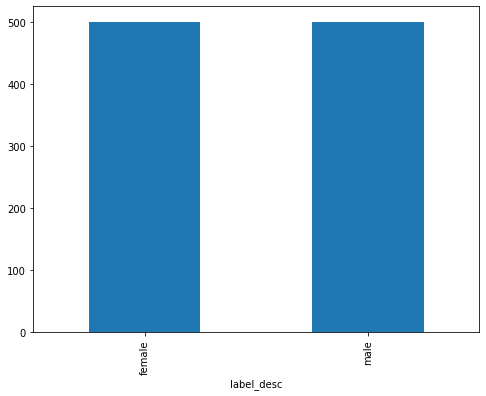

In [222]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_1000.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(df_1000['label_desc'].value_counts())
plt.show()

In [223]:
df_0 = pd.concat([df_1000, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(2200, 2902)

In [224]:
X_train = features[:1000]
vali_X = features[1000:1200] # altogether 200 posts in validation set
y_train = labels[:1000]
vali_Y = labels[1000:1200]
X_test = features[1200:]
y_test = labels[1200:]
print(len(X_test))

f1_1000 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


1000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.6047529706066291
Grid: {'C': 0.001}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=0.001)
Accuracy Score : 0.559
Precision Score : 0.5590002360009441
Recall Score : 0.559
F1 Score : 0.5589995589995591


In [225]:
########################### Data Size = 2568 ##################################

male      1284
female    1284
Name: label_desc, dtype: int64


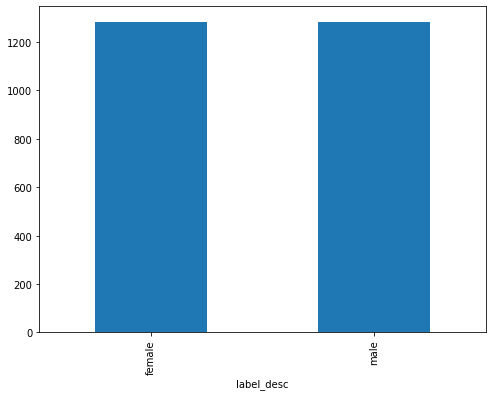

In [226]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
final_train_df.groupby('label_desc').sentences.count().plot.bar(ylim=0)
print(final_train_df['label_desc'].value_counts())
plt.show()

In [227]:
df_0 = pd.concat([final_train_df, vali_df], axis=0)
df = pd.concat([df_0, test_df], axis=0)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', ngram_range=(1, 2), token_pattern = r"(?u)\b\w+\b")
features = tfidf.fit_transform(df.sentences).toarray()
labels = df.category_id
features.shape #each of 5000 consumer complaint narratives is represented by 4503 features

(3768, 4858)

In [228]:
X_train = features[:2568]
vali_X = features[2568:2768] # altogether 200 posts in validation set
y_train = labels[:2568]
vali_Y = labels[2568:2768]
X_test = features[2768:]
y_test = labels[2768:]
print(len(X_test))

f1_2568 = SVCmodel(X_train, y_train, vali_X, vali_Y, X_test, y_test)


1000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Best score: 0.6298519407763106
Grid: {'C': 10}
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
####################################
By using SVC model, the best parameter and its evaluation metrics are:
Best parameters: LinearSVC(C=10)
Accuracy Score : 0.518
Precision Score : 0.5180002880046081
Recall Score : 0.518
F1 Score : 0.5179980719922879


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [229]:
print(str(f1_100), "\n",
      str(f1_200), "\n",
      str(f1_300), "\n",
      str(f1_400), "\n",
      str(f1_500), "\n",
      str(f1_600), "\n",
      str(f1_700), "\n",
      str(f1_800), "\n",
      str(f1_900), "\n",
      str(f1_1000), "\n",
      str(f1_2568), "\n",)

0.501556865592655 
 0.5078261714952363 
 0.5326593086359956 
 0.5625283453537702 
 0.5379704301075269 
 0.535524376962009 
 0.5582574307410757 
 0.5560662244738079 
 0.5559715821812596 
 0.5589995589995591 
 0.5179980719922879 

